In [40]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

In [41]:
dataset = pd.read_excel('Data.xlsx')

In [42]:
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,Null,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,Null,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,Null,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,Null,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,Null,13302


In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [44]:
#Checking null value in each features
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [45]:
dataset[dataset['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,Null,7480


### Above as only 1 null value so lets fill manully

In [46]:
dataset['Route']=dataset['Route'].fillna('DEL → COK')

In [47]:
dataset['Total_Stops']=dataset['Total_Stops'].fillna('non-stop')

In [48]:
dataset.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,Null,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,Null,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,Null,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,Null,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,Null,13302


### Additional_Info contains null value lets check and take a decision whether need to fillna or drop column

In [49]:
dataset['Additional_Info']=dataset['Additional_Info'].replace('Null', np.nan)

In [50]:
dataset.isnull().sum()/10683*100

Airline             0.000000
Date_of_Journey     0.000000
Source              0.000000
Destination         0.000000
Route               0.000000
Dep_Time            0.000000
Arrival_Time        0.000000
Duration            0.000000
Total_Stops         0.000000
Additional_Info    78.133483
Price               0.000000
dtype: float64

### 78% data is null so droping the column.

In [51]:
dataset=dataset.drop(['Additional_Info'],axis=1)

In [52]:
dataset.Destination.unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [53]:
#Renaming delhi to new delhi

dataset['Destination']=dataset['Destination'].replace({"Delhi":"New Delhi"})

## Feature Engineering

In [54]:
dataset.sample(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price
4879,Multiple carriers,1/06/2019,Delhi,Cochin,DEL → BOM → COK,13:00,21:00,8h,1 stop,13587
947,Jet Airways,12/05/2019,Kolkata,Banglore,CCU → BOM → BLR,21:10,10:05 13 May,12h 55m,1 stop,13941
2658,Jet Airways,12/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 13 Jun,22h 55m,2 stops,13014
35,IndiGo,27/06/2019,Delhi,Cochin,DEL → BOM → COK,10:35,21:00,10h 25m,1 stop,5894
5804,SpiceJet,1/06/2019,Banglore,New Delhi,BLR → DEL,05:55,08:35,2h 40m,non-stop,3625
2948,Jet Airways,12/05/2019,Kolkata,Banglore,CCU → GAU → BLR,10:20,17:35,7h 15m,1 stop,9358
1304,IndiGo,18/06/2019,Kolkata,Banglore,CCU → BLR,14:25,16:55,2h 30m,non-stop,4804
9271,IndiGo,3/03/2019,Delhi,Cochin,DEL → COK,21:05,00:20 04 Mar,3h 15m,non-stop,7673
2063,Jet Airways,24/06/2019,Delhi,Cochin,DEL → BOM → COK,15:00,19:00 25 Jun,28h,1 stop,10262
4358,Vistara,24/05/2019,Kolkata,Banglore,CCU → DEL → BLR,07:10,22:40,15h 30m,1 stop,9397


In [55]:
dataset['Date_of_Journey']=dataset['Date_of_Journey'].astype('datetime64[ns]')

C:\Users\sathv\AppData\Local\Temp\ipykernel_5816\247591060.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset['Date_of_Journey']=dataset['Date_of_Journey'].astype('datetime64[ns]')


#### Extracting day month and year from date of journey

In [56]:
dataset['Day']=dataset['Date_of_Journey'].dt.day_name()
dataset['Month']=dataset['Date_of_Journey'].dt.month_name()
dataset['Year']=dataset['Date_of_Journey'].dt.year

In [57]:
#create new feature called weekday or not.
dataset['Weekend']=np.where(dataset['Day']=='Saturday',1,np.where(dataset['Day']=='Sunday',1,0))

In [58]:
#create new feature called direct or connecting flight.
dataset['Route_Type']=np.where(dataset['Total_Stops']=='non-stop','Direct','Connecting')

In [59]:
# Define a function to determine the day part
def day_part(arrival_time):
    hour = int(arrival_time.split(':')[0])
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the Arrival_Time column
dataset['day_part'] = dataset['Dep_Time'].apply(day_part)


In [60]:
dataset.sample(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Day,Month,Year,Weekend,Route_Type,day_part
9925,Jet Airways,2019-06-09,Mumbai,Hyderabad,BOM → HYD,10:20,11:50,1h 30m,non-stop,5678,Sunday,June,2019,1,Direct,Morning
10206,Air India,2019-05-27,Delhi,Cochin,DEL → TRV → COK,05:15,06:50 28 May,25h 35m,1 stop,8425,Monday,May,2019,0,Connecting,Night
9872,Multiple carriers,2019-03-21,Delhi,Cochin,DEL → BOM → COK,14:00,21:00,7h,1 stop,13062,Thursday,March,2019,0,Connecting,Afternoon
10612,Jet Airways,2019-03-09,Banglore,New Delhi,BLR → BOM → DEL,08:00,21:20,13h 20m,1 stop,11087,Saturday,March,2019,1,Connecting,Morning
3225,Multiple carriers,2019-06-01,Delhi,Cochin,DEL → BOM → COK,10:35,19:00,8h 25m,1 stop,11200,Saturday,June,2019,1,Connecting,Morning


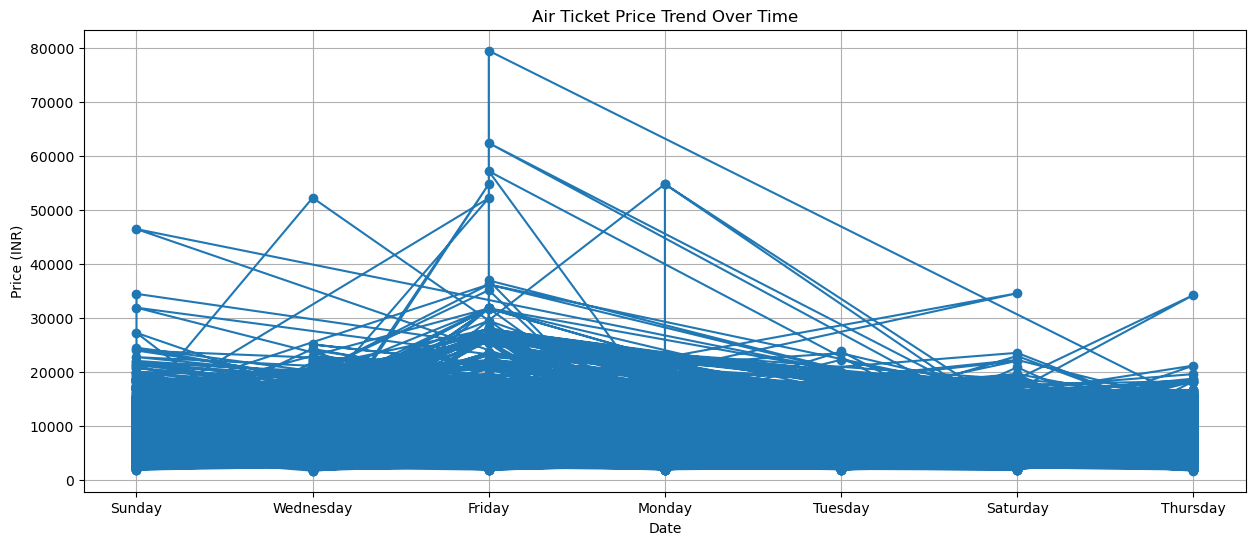

In [61]:
#Line Chart: Air Ticket Price Trend Over Time


import matplotlib.pyplot as plt

figsize = (15, 6)
# Create the figure with the specified size
plt.figure(figsize=figsize)
plt.plot(dataset['Day'], dataset['Price'], marker='o')
plt.title('Air Ticket Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.grid(True)
plt.show()


#### Friday price is high compared to other week day

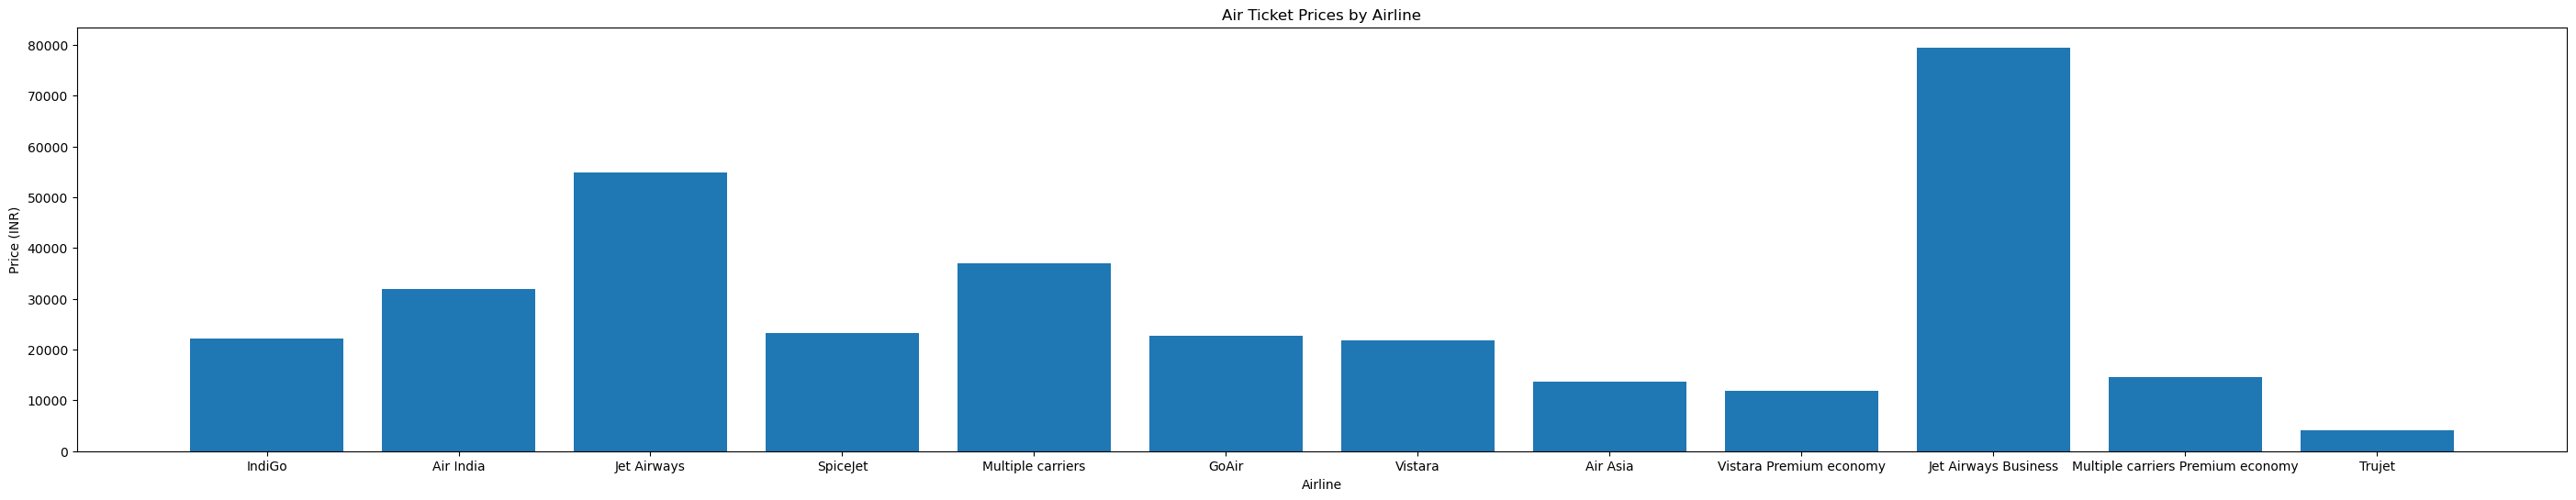

In [62]:
#Bar Chart:  Air Ticket Prices by Airline

import matplotlib.pyplot as plt

figsize = (35, 6)
# Create the figure with the specified size
plt.figure(figsize=figsize)

# Create the bar chart
plt.bar(dataset['Airline'], dataset['Price'])
plt.title('Air Ticket Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price (INR)')
plt.show()

### JetAirway price is more compare to other airplane

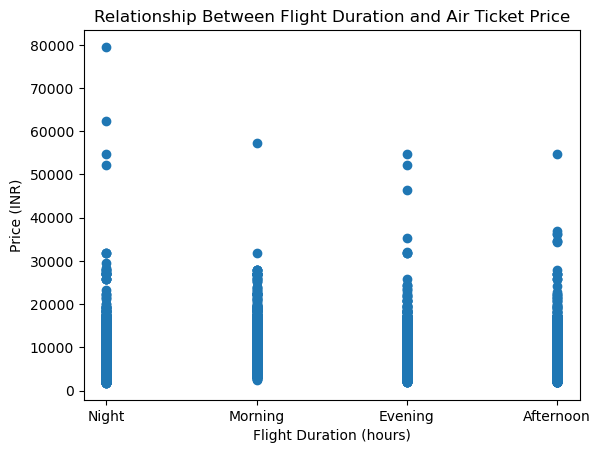

In [63]:
#Scatter Plot: Relationship Between Flight Duration and Air Ticket Price

import matplotlib.pyplot as plt

# Create the scatter plot
plt.scatter(dataset['day_part'], dataset['Price'])
plt.title('Relationship Between Flight Duration and Air Ticket Price')
plt.xlabel('Flight Duration (hours)')
plt.ylabel('Price (INR)')
plt.show()

### Flight Price is almost Same

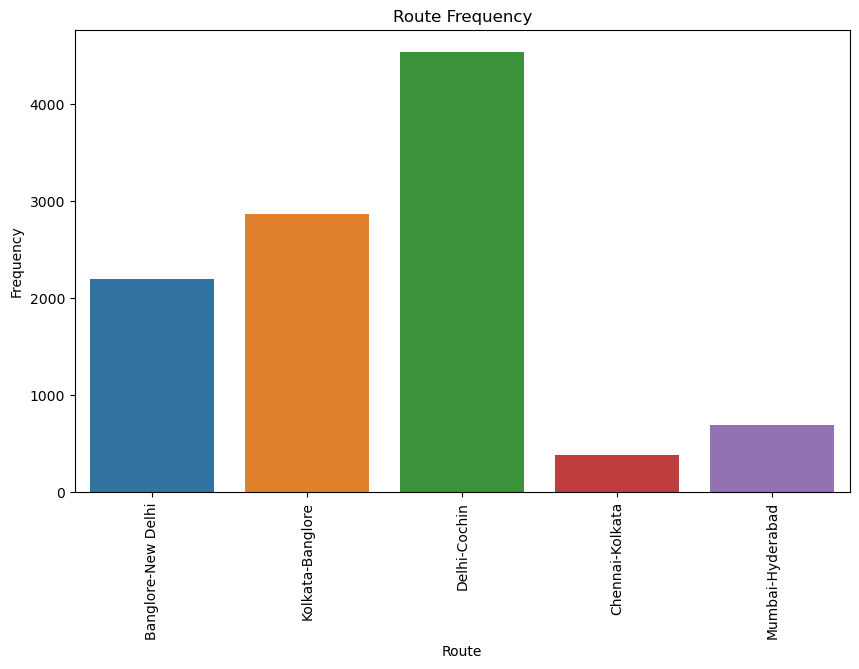

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar chart with seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x=dataset['Source'] + '-' + dataset['Destination'], data=dataset)
plt.xlabel('Route')
plt.ylabel('Frequency')
plt.title('Route Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

### Delhi to cochin more ticket has been booked

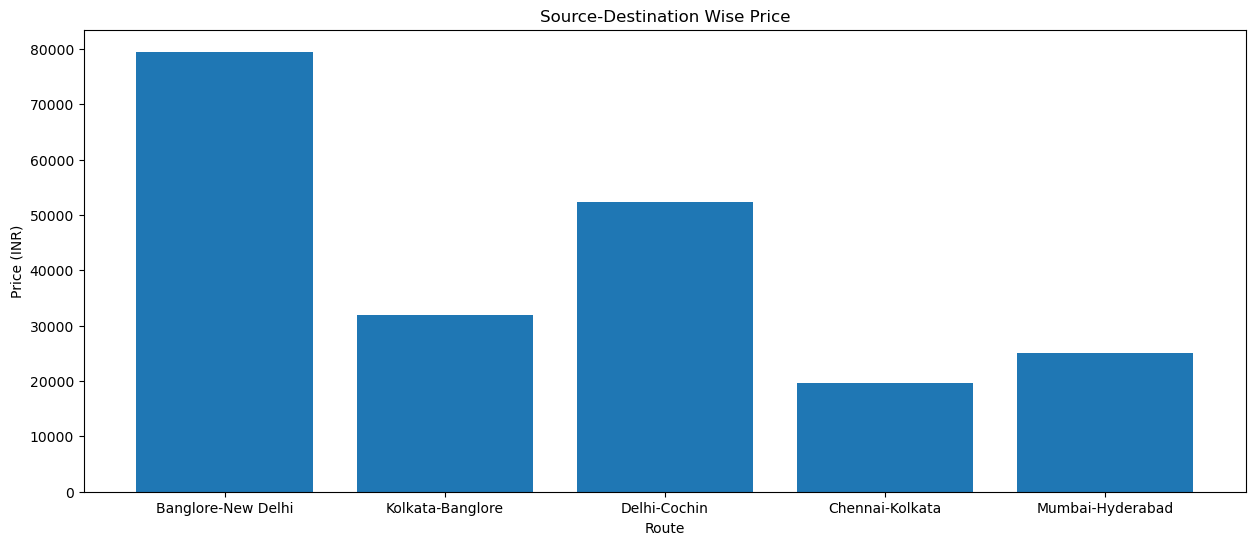

In [65]:
# Bar Chart: Source-Destination Wise Price

import matplotlib.pyplot as plt
figsize = (15, 6)
# Create the figure with the specified size
plt.figure(figsize=figsize)
# Plot the Price column grouped by Source and Destination
plt.bar(dataset['Source'] + '-' + dataset['Destination'], dataset['Price'])
plt.title('Source-Destination Wise Price')
plt.xlabel('Route')
plt.ylabel('Price (INR)')

plt.show()


### Banglore to new Delhi cost is more than other source-destination

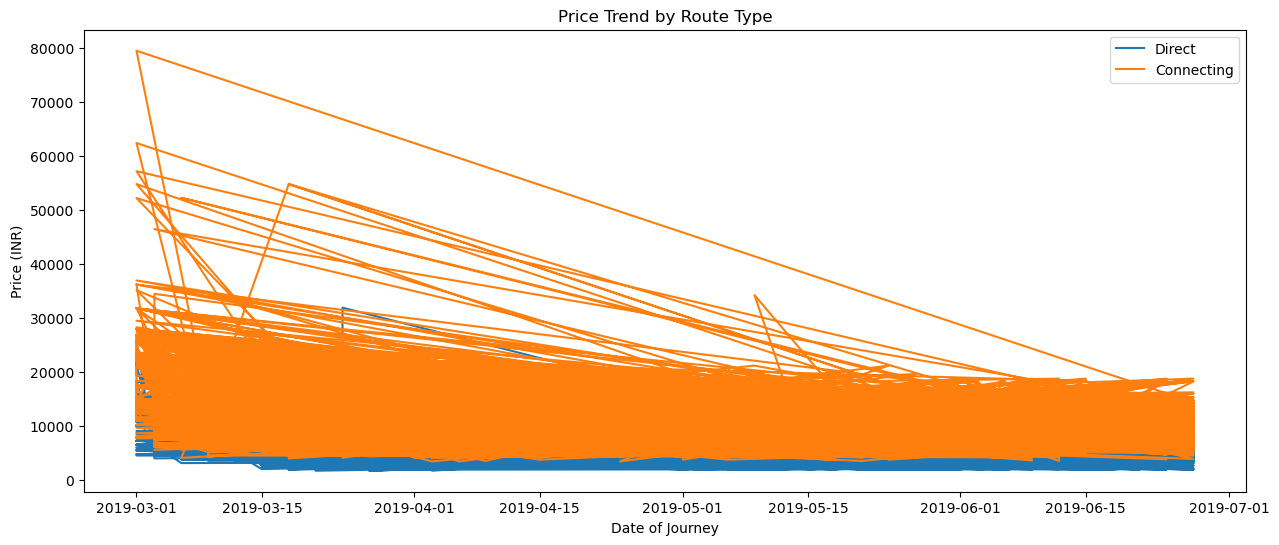

In [66]:
#Line Chart: Price Trend by Route Type

import matplotlib.pyplot as plt
figsize = (15, 6)
# Create the figure with the specified size
plt.figure(figsize=figsize)
# Plot the Price column over Date_of_Journey grouped by Route_Type
for route_type in dataset['Route_Type'].unique():
    plt.plot(dataset.loc[dataset['Route_Type'] == route_type, 'Date_of_Journey'], dataset.loc[dataset['Route_Type'] == route_type, 'Price'], label=route_type)
plt.title('Price Trend by Route Type')
plt.xlabel('Date of Journey')
plt.ylabel('Price (INR)')
plt.legend()

plt.show()

### Connecting flight price is more than direct flight

In [67]:
def try_convert_to_float(x):
    try:
        return float(x.split('h')[0]) + float(x.split('h')[1].split('m')[0])/60
    except ValueError:
        return 0
dataset['Duration_Hours'] = dataset['Duration'].apply(lambda x: try_convert_to_float(x))

In [68]:
dataset['Duration_Category'] = pd.cut(dataset['Duration_Hours'], bins=[-1,3,8,24,48], labels=['less than 3hrs','between 3hrs to 8hrs', 'between 8hrs to 24hrs','more than 1day'])

In [69]:
dataset.head(2) 

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Day,Month,Year,Weekend,Route_Type,day_part,Duration_Hours,Duration_Category
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,3897,Sunday,March,2019,1,Direct,Night,2.833333,less than 3hrs
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,7662,Wednesday,May,2019,0,Connecting,Night,7.416667,between 3hrs to 8hrs


In [70]:
dataset.Duration_Category.unique()

['less than 3hrs', 'between 3hrs to 8hrs', 'between 8hrs to 24hrs', 'more than 1day']
Categories (4, object): ['less than 3hrs' < 'between 3hrs to 8hrs' < 'between 8hrs to 24hrs' < 'more than 1day']

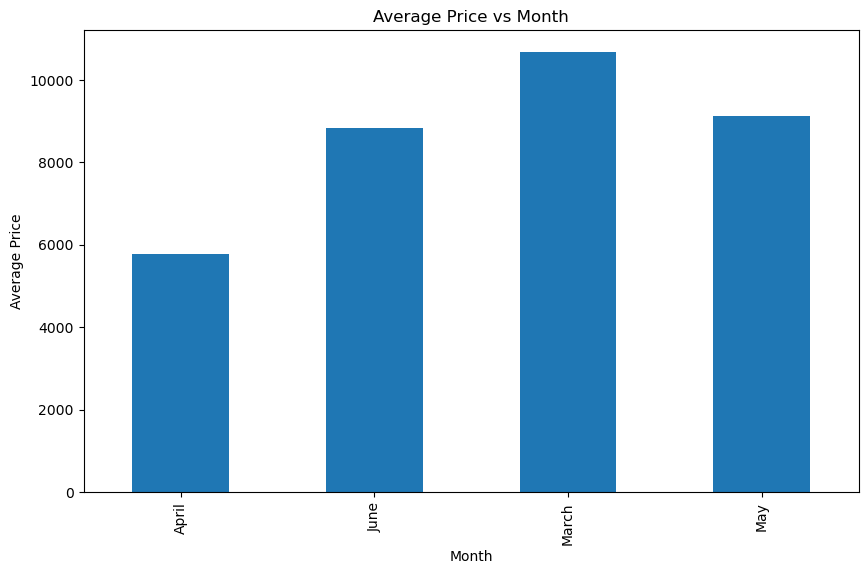

In [71]:
avg_price_by_Month = dataset.groupby('Month')['Price'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
avg_price_by_Month.plot(kind='bar')
plt.title('Average Price vs Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()


### During Match month Flight price get increase

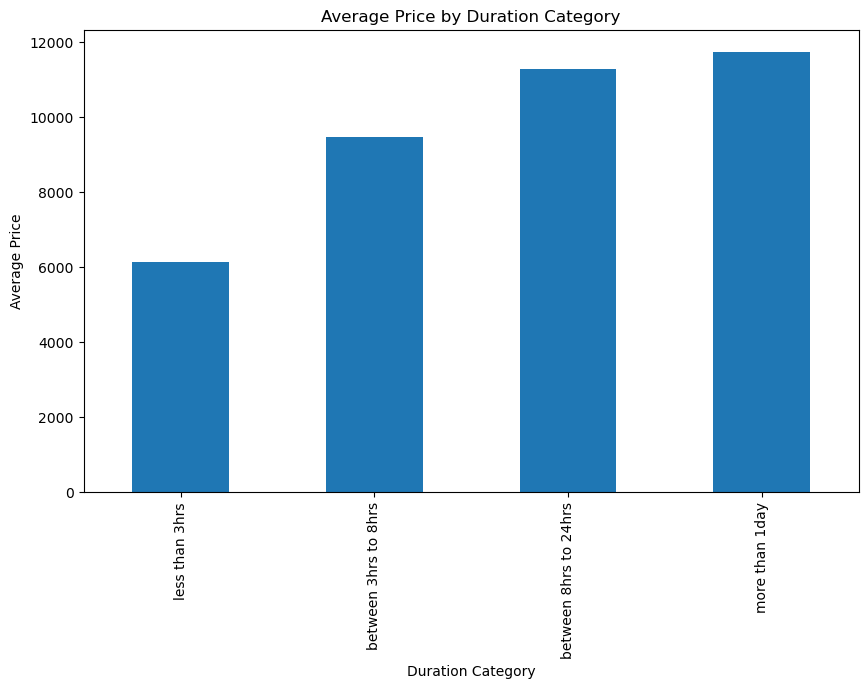

In [72]:
avg_price_by_duration = dataset.groupby('Duration_Category')['Price'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
avg_price_by_duration.plot(kind='bar')
plt.title('Average Price by Duration Category')
plt.xlabel('Duration Category')
plt.ylabel('Average Price')
plt.show()

### Less duration average price gets reduce.

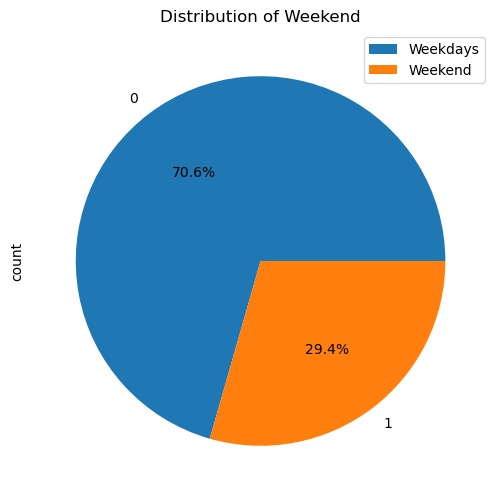

In [73]:

Weekend = dataset['Weekend'].value_counts()
plt.figure(figsize=(8, 6))
Weekend.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Weekend')
plt.legend(labels=['Weekdays', 'Weekend'])
plt.show()

### Majority flights booked on Weekdays

In [74]:
#Dropping the irrevalent feature
dataset.drop(['Date_of_Journey','Route','Dep_Time','Arrival_Time','Duration','Year'],axis=1,inplace=True)


In [75]:
# Define column transformer for preprocessing
x=dataset.drop(['Price'],axis=1)
y=dataset['Price']
categorical_feature = x.select_dtypes(include=['object']).columns
numerical_feature = x.select_dtypes(include=['int32','int64','float64']).columns

In [76]:
dataset.head(3)

,Airline,Source,Destination,Total_Stops,Price,Day,Month,Weekend,Route_Type,day_part,Duration_Hours,Duration_Category
0,IndiGo,Banglore,New Delhi,non-stop,3897,Sunday,March,1,Direct,Night,2.833333,less than 3hrs
1,Air India,Kolkata,Banglore,2 stops,7662,Wednesday,May,0,Connecting,Night,7.416667,between 3hrs to 8hrs
2,Jet Airways,Delhi,Cochin,2 stops,13882,Sunday,June,1,Connecting,Morning,0.000000,less than 3hrs


## Handling Char/Object

In [77]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['Airline']=le.fit_transform(dataset['Airline'])
dataset['Source']=le.fit_transform(dataset['Source'])
dataset['Destination']=le.fit_transform(dataset['Destination'])
dataset['Total_Stops']=le.fit_transform(dataset['Total_Stops'])
dataset['Day']=le.fit_transform(dataset['Day'])
dataset['Source']=le.fit_transform(dataset['Source'])
dataset['Month']=le.fit_transform(dataset['Month'])
dataset['Route_Type']=le.fit_transform(dataset['Route_Type'])
dataset['day_part']=le.fit_transform(dataset['day_part'])
dataset['Duration_Category']=le.fit_transform(dataset['Duration_Category'])

## Statistical test

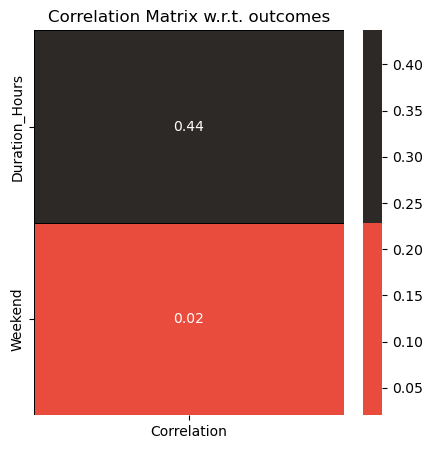

In [78]:
colors = ['#E94B3C', '#2D2926']
corr = dataset[numerical_feature].corrwith(dataset['Price']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlation']
plt.subplots(figsize = (5,5))
sns.heatmap(corr, annot=True, cmap=colors, linewidths = 0.4, linecolor='black')
plt.title("Correlation Matrix w.r.t. outcomes")
plt.show()

### Duration gives more wieghtage

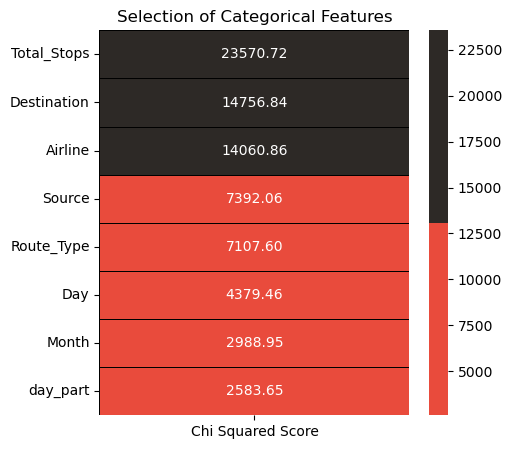

In [79]:
# Chi-Square Test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

colors = ['#E94B3C', '#2D2926']
# Chi-Square Test :
features = dataset.loc[:,categorical_feature] # char
target = dataset['Price'] # cat
best_features = SelectKBest(score_func = chi2, k='all')
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(data = fit.scores_, index= list(categorical_feature),
                             columns = ['Chi Squared Score'])

plt.subplots(figsize=(5,5))
sns.heatmap(featureScores.sort_values(ascending = False, by = 'Chi Squared Score'),
            annot=True, cmap = colors, linewidths = 0.4, linecolor = 'black', fmt = '.2f');
plt.title('Selection of Categorical Features')
plt.show()

### Total_Stops,Destination and Airline give more wieghtage

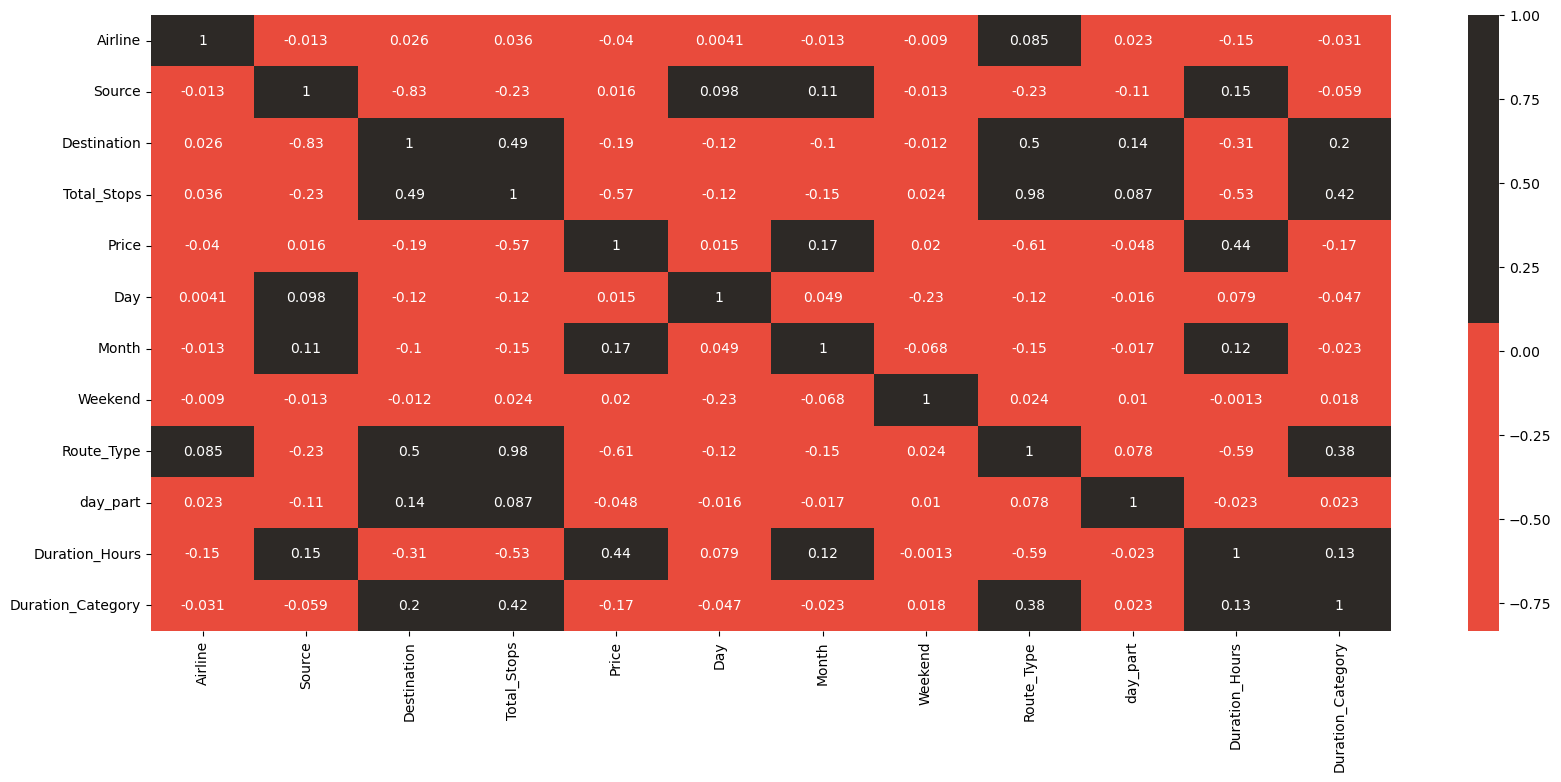

In [80]:
plt.figure(figsize=(20,8))
sns.heatmap(dataset.corr(), cmap=colors, annot=True);

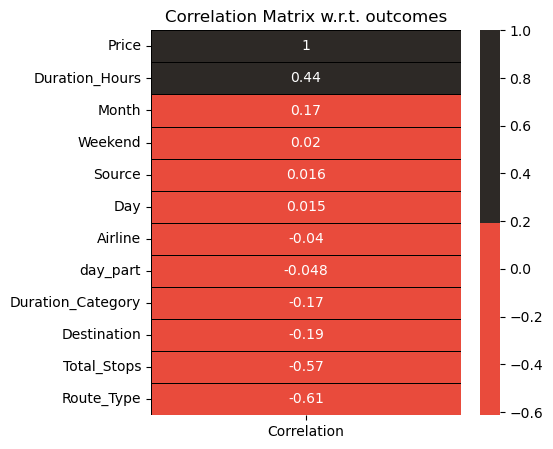

In [81]:
corr = dataset.corrwith(dataset['Price']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlation']
plt.subplots(figsize = (5,5))
sns.heatmap(corr, annot=True, cmap=colors, linewidths = 0.4, linecolor='black')
plt.title("Correlation Matrix w.r.t. outcomes")
plt.show()

In [82]:
x1=dataset.drop(['Price','Route_Type'],axis=1)
y1=dataset['Price']



In [83]:
# split the data into training and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.3, random_state=42)

In [84]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train_sc = scale.fit_transform(x_train)
x_test_sc = scale.transform(x_test)
x_train_sc = pd.DataFrame(x_train_sc,columns=x_train.columns)
x_test_sc = pd.DataFrame(x_test_sc,columns=x_test.columns)

In [85]:
x_train_sc.head(2)

,Airline,Source,Destination,Total_Stops,Day,Month,Weekend,day_part,Duration_Hours,Duration_Category
0,0.017269,1.749460,0.350768,1.411795,0.435686,-0.795303,-0.647283,0.384345,-0.934660,0.685852
1,0.869660,0.050329,-0.336613,-0.805564,-0.076829,0.201391,1.544919,0.384345,0.009976,-0.480050


In [86]:
x_test_sc.head(2)

,Airline,Source,Destination,Total_Stops,Day,Month,Weekend,day_part,Duration_Hours,Duration_Category
0,0.017269,0.899894,-1.023993,-0.805564,-0.589345,1.198086,1.544919,1.385785,0.337706,-0.480050
1,-0.835122,0.050329,-0.336613,-0.805564,-1.101860,-0.795303,-0.647283,0.384345,-1.108164,0.685852


In [87]:
# Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
variable = x_train_sc
vif = pd.DataFrame()
vif['variance_inflation_factor'] = [variance_inflation_factor(variable, i) for i in range(variable.shape[1])]
vif['features'] = x1.columns
vif

,variance_inflation_factor,features
0,1.029660,Airline
1,4.132965,Source
2,5.177279,Destination
3,2.508102,Total_Stops
4,1.074784,Day
5,1.045958,Month
6,1.063495,Weekend
7,1.022512,day_part
8,1.794383,Duration_Hours
9,1.534652,Duration_Category


### Total_stops and Route_type is Extremely high multicollinearity

In [88]:
# Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
variable = x_train_sc
vif = pd.DataFrame()
vif['variance_inflation_factor'] = [variance_inflation_factor(variable, i) for i in range(variable.shape[1])]
vif['features'] = x_train_sc.columns
vif

,variance_inflation_factor,features
0,1.029660,Airline
1,4.132965,Source
2,5.177279,Destination
3,2.508102,Total_Stops
4,1.074784,Day
5,1.045958,Month
6,1.063495,Weekend
7,1.022512,day_part
8,1.794383,Duration_Hours
9,1.534652,Duration_Category


In [89]:
from statsmodels.regression.linear_model import OLS
import statsmodels.regression.linear_model as smf

In [90]:
#Without scaled data
reg_model = smf.OLS(endog=y_train, exog=x_train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.847
Method:                 Least Squares   F-statistic:                              4153.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):                        0.00
Time:                        17:40:08   Log-Likelihood:                         -72631.
No. Observations:                7478   AIC:                                  1.453e+05
Df Residuals:                    7468   BIC:                                  1.454e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Airline             195.1533     19.063     10.237      0.000     157.784     232.522
Source             1627.9814     53.929     30.187      0.000    1522.265    1733.698
Destination        1864.1831     51.215     36.399      0.000    1763.788    1964.578
Total_Stops       -1388.5381     40.543    -34.249      0.000   -1468.014   -1309.062
Day                 138.8333     23.595      5.884      0.000      92.581     185.086
Month               724.1932     46.113     15.705      0.000     633.798     814.588
Weekend            1047.3140    102.109     10.257      0.000     847.151    1247.477
day_part            278.0035     45.746      6.077      0.000     188.328     367.679
Duration_Hours      168.9931      6.868     24.606      0.000     155.530     182.456
Duration_Category    57.9062     66.788      0.867      0.386     -73.017     188.829
==============================================================================
Omnibus:                     4848.096   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           212618.987
Skew:                           2.512   Prob(JB):                         0.00
Kurtosis:                      28.635   Cond. No.                         30.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Selection

In [91]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [92]:
# Initialize the models                                                                                                                              
linear_model = LinearRegression()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
decisiontree = DecisionTreeRegressor()

In [93]:
# Model Training
linear_model.fit(x_train_sc, y_train)
random_forest.fit(x_train_sc, y_train)
gradient_boosting.fit(x_train_sc, y_train)
decisiontree.fit(x_train_sc, y_train)

DecisionTreeRegressor()

In [94]:
x_train_sc.shape

(7478, 10)

In [95]:
y_train.shape

(7478,)

In [96]:
# Model Evaluation
from sklearn.metrics import r2_score, mean_absolute_error

# make prediction
y_predtr_lr = linear_model.predict(x_train_sc)
y_predtr_rf = random_forest.predict(x_train_sc)
y_predtr_gd = gradient_boosting.predict(x_train_sc)
y_predtr_dt = decisiontree.predict(x_train_sc)

# Calcualte metics
mae_lr = mean_absolute_error(y_train, y_predtr_lr)
mae_rf = mean_absolute_error(y_train, y_predtr_rf)
mae_gd = mean_absolute_error(y_train, y_predtr_gd)
mae_dt = mean_absolute_error(y_train, y_predtr_dt)

r2_lr = r2_score(y_train, y_predtr_lr)
r2_rf = r2_score(y_train, y_predtr_rf)
r2_gd = r2_score(y_train, y_predtr_gd)
r2_dt = r2_score(y_train, y_predtr_dt)

print(f'Linear Regression MAE : {mae_lr}, R2:{r2_lr}')
print(f'Random Forest MAE : {mae_rf}, R2:{r2_rf}')
print(f'Gradient Boosting MAE : {mae_gd}, R2:{r2_gd}')
print(f'DecisionTree MAE : {mae_dt}, R2:{r2_dt}')

Linear Regression MAE : 2601.7239797286925, R2:0.3698785334795872
Random Forest MAE : 814.7096232834002, R2:0.9114126966066267
Gradient Boosting MAE : 1693.5734048813142, R2:0.7027891678542293
DecisionTree MAE : 545.3867130154279, R2:0.9338839762121619


In [97]:
# Model Evaluation
from sklearn.metrics import r2_score, mean_absolute_error

# make prediction
y_pred_lr = linear_model.predict(x_test_sc)
y_pred_rf = random_forest.predict(x_test_sc)
y_pred_gd = gradient_boosting.predict(x_test_sc)
y_pred_dt = decisiontree.predict(x_test_sc)

# Calcualte metics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_gd = mean_absolute_error(y_test, y_pred_gd)
mae_dt = mean_absolute_error(y_test, y_pred_dt)

r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)
r2_gd = r2_score(y_test, y_pred_gd)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Linear Regression MAE : {mae_lr}, R2:{r2_lr}')
print(f'Random Forest MAE : {mae_rf}, R2:{r2_rf}')
print(f'Gradient Boosting MAE : {mae_gd}, R2:{r2_gd}')
print(f'DecisionTree MAE : {mae_dt}, R2:{r2_dt}')

Linear Regression MAE : 2567.8663942398966, R2:0.39550570432553933
Random Forest MAE : 1499.2834811895937, R2:0.7149147973227195
Gradient Boosting MAE : 1713.7441195596446, R2:0.6900536041181862
DecisionTree MAE : 1684.5621173181858, R2:0.5951473225561486


## Overall, the Random Forest and Decision Tree models perform well, but show signs of slight overfitting. The Gradient Boosting model has stable performance, while the Linear Regression model underfits the data.

Text(0, 0.5, 'Price')

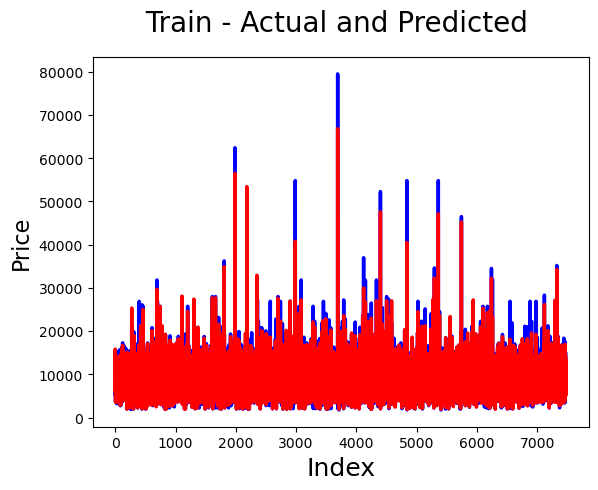

In [98]:
c = [i for i in range(0,7478,1)] # generating index 
fig = plt.figure() 
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_predtr_rf, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle(' Train - Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Price', fontsize=16) 

Text(0, 0.5, 'Price')

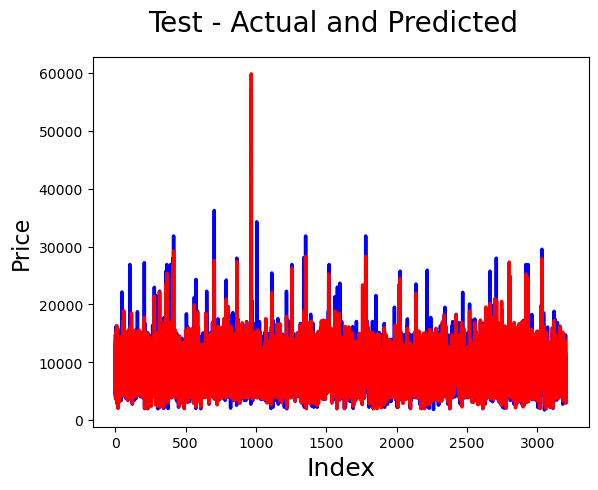

In [99]:
c = [i for i in range(0,3205,1)] # generating index 
fig = plt.figure() 
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_pred_rf, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Test - Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Price', fontsize=16)     

C:\Users\sathv\AppData\Local\Temp\ipykernel_5816\1871662703.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-y_pred_rf),bins=50)


Text(0, 0.5, 'Index')

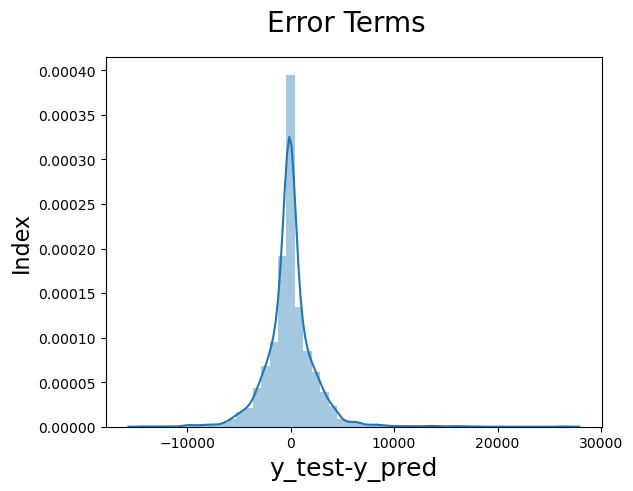

In [100]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred_rf),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16) 

### Error loss is slighty normal distrubuted

In [101]:
# Regularization method
# L1 - Lasso
# L2 - Ridge
# l1 + L2 - ElasticNet

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.3)
lasso.fit(x_train_sc, y_train)
y_pred_l1_train = lasso.predict(x_train_sc)
y_pred_l1_test = lasso.predict(x_test_sc)
print("Lasso_Model_Training_Accuracy", r2_score(y_train, y_pred_l1_train))
print()
print("Lasso_Model_Test_Accuracy", r2_score(y_test, y_pred_l1_test))

Lasso_Model_Training_Accuracy 0.36987848841235826

Lasso_Model_Test_Accuracy 0.39550381047302297


In [102]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.3)
ridge.fit(x_train_sc, y_train)
y_pred_l2_train = ridge.predict(x_train_sc)
y_pred_l2_test = ridge.predict(x_test_sc)
print("ridge_Model_Training_Accuracy", r2_score(y_train, y_pred_l2_train))
print()
print("ridge_Model_Test_Accuracy", r2_score(y_test, y_pred_l2_test))

ridge_Model_Training_Accuracy 0.36987853266308046

ridge_Model_Test_Accuracy 0.3955061716275867


In [103]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.3, l1_ratio=0.1)
elastic.fit(x_train_sc, y_train)
y_pred_el_train = elastic.predict(x_train_sc)
y_pred_el_test = elastic.predict(x_test_sc)
print("elastic_Model_Training_Accuracy", r2_score(y_train, y_pred_el_train))
print()
print("elastic_Model_Test_Accuracy", r2_score(y_test, y_pred_el_test))

elastic_Model_Training_Accuracy 0.3562928825810726

elastic_Model_Test_Accuracy 0.38117424850649184


In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [300,400,500],
    'max_depth': [None, 5],
    'min_samples_split': [5,10,15,20],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit GridSearchCV to the training data
grid_search.fit(x_train_sc, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best score (negative MAE)
print("Best score (negative MAE):", grid_search.best_score_)

# Use the best hyperparameters to make predictions
y_pred = grid_search.predict(x_test_sc)


Best hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500}
Best score (negative MAE): -1594.0910137418073


## THE END